In [32]:
import torch
import torch.nn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
from copy import deepcopy

In [56]:
train_rawdata = datasets.MNIST(root = 'data', # 경로 의미하는 것임
                               train=True, # 참 -> 트레인 데이터, 거짓 ->  테스트데이터 줌
                               download=True, # 다운
                               transform = transforms.ToTensor()) # 텐서로 바꿔
test_dataset = datasets.MNIST(root = 'dataset',
                               train=False,
                               download=True,
                               transform = transforms.ToTensor())
print('number of training data: ', len(train_rawdata))
print('number of test data: ', len(test_dataset))

number of training data:  60000
number of test data:  10000


In [34]:
VALIDATION_RATE = 0.2
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_rawdata)), # x index번호
    train_rawdata.targets, # y
    stratify = train_rawdata.targets,
    test_size=VALIDATION_RATE
)

In [35]:
train_dataset = Subset(train_rawdata, train_indices) # 주어진 인덱스에 해당하는 것만 가져온다.
# train_rawdata 는 train 의 전체 데이터
# 여기서 train과 val로 나눴으니 새로운 train 들을 선택해야 함
# 그래서 Subset을 이용함
validation_dataset = Subset(train_rawdata, val_indices)

In [36]:
# 데이터셋 확인
print( len (train_dataset), len(validation_dataset), len(test_dataset))

48000 12000 10000


In [57]:
# 미니배치 
batch_size = 128
train_batches = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batches = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [38]:
x_train, y_train = next(iter(train_batches)) # 하나만 가져와서 모양 보기
print(x_train.shape, y_train.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [39]:
# x_train[index, :, :, :].shape

In [40]:
# x_train[index, :, :, :].numpy().reshape(28, 28).shape

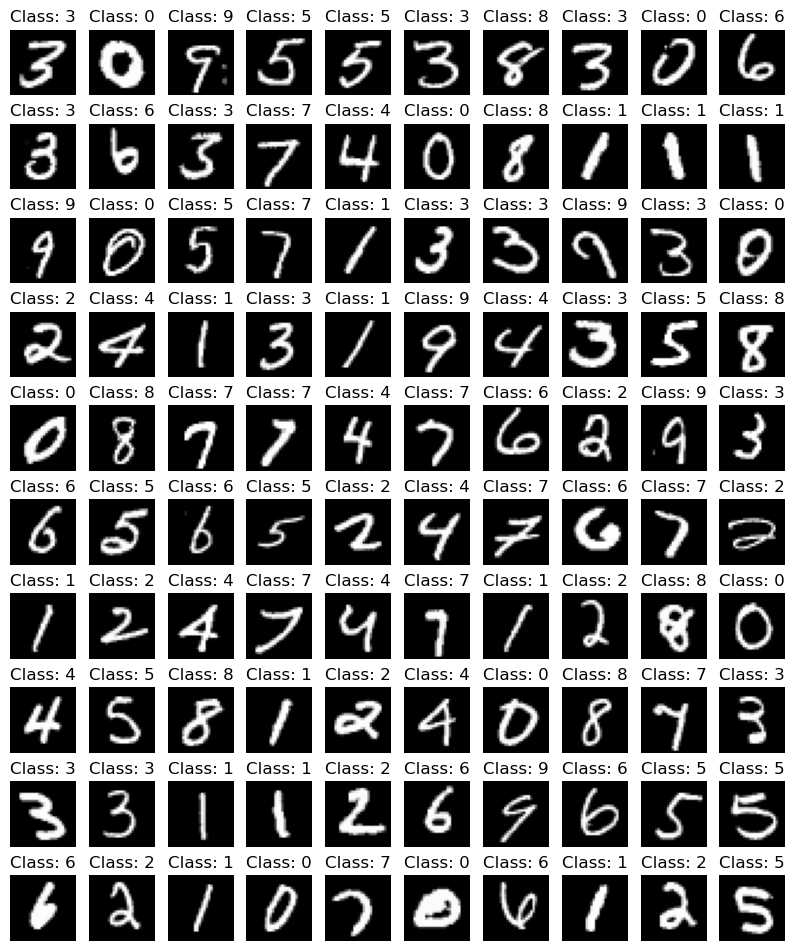

In [41]:
# %matplotlib inline

plt.figure(figsize=(10,12))

for index in range(100):
    plt.subplot(10, 10, index + 1)
    plt.axis('off')
    plt.imshow(x_train[index,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: ' + str(y_train[index].item()))

In [42]:
# 미니배치 하나만 가져와서 이미지 visualization
x_train, y_train = next(iter(train_batches))
print(x_train.shape, y_train.shape)
print(x_train.size(0))
print(x_train.view(x_train.size(0), -1).shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])
128
torch.Size([128, 784])


In [43]:
class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.linear_layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0, 1),
            nn.Linear(256,256),
            nn.LeakyReLU(0, 1),
            nn.Linear(256,128),
            nn.LeakyReLU(0,1),
            nn.Linear(128, output_dim),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        y = self.linear_layers(x)
        return y
        

In [44]:
minibatch_size = 128
input_dim = 28*28
output_dim = 10
model = Model(input_dim, output_dim)

loss_func = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

In [45]:
# saving best model
# model.stat_dict() : 사전 객체로 추출이 가능하다
# model.load_state_dict(x) : model.stat_dict() 에 저장된 매개변수를 가져올 수 있다.

In [46]:
from copy import deepcopy

In [47]:
def train_model(model, early_stop, n_epochs, progress_interval):
    
    train_losses, valid_losses, lowest_loss = list(), list(), np.inf
    
    for epoch in range(n_epochs):
        
        train_loss, valid_loss = 0, 0
        
        # train the model
        model.train()
        for x_minibatch, y_minibatch in train_batches:
            y_minibatch_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
            loss = loss_func(y_minibatch_pred, y_minibatch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        train_loss = train_loss / len(train_batches)
        train_losses.append(train_loss)
        
        # validate the model
        model.eval()
        with torch.no_grad():
            for x_minibatch, y_minibatch in val_batches:
                y_minibatch_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
                loss = loss_func(y_minibatch_pred, y_minibatch)
                valid_loss += loss.item()
                
        valid_loss = valid_loss / len(val_batches)
        valid_losses.append(valid_loss)
        
        if valid_losses[-1] < lowest_loss:
            lowest_loss = valid_losses[-1]
            lowest_epoch = epoch
            best_model = deepcopy(model.state_dict())
        else:
            if early_stop > 0 and lowest_epoch + early_stop < epoch:
                print("early stopped" , epoch, "epochs")
                break
        
        if(epoch % progress_interval) == 0:
            print(train_losses[-1], valid_losses[-1], lowest_loss, lowest_epoch, epoch)
            
    model.load_state_dict(best_model)
    return model, lowest_loss, train_losses, valid_losses
            

In [48]:
nb_epochs = 30
progress_interval = 3
early_stop = 5

model, lowest_loss, train_losses, valid_losses = train_model(model, early_stop, nb_epochs, progress_interval)

0.3919877856373787 0.1929656004017972 0.1929656004017972 0 0
0.06812100999429822 0.09461315400264364 0.09461315400264364 3 3
0.032510785243163504 0.0951225554689448 0.08534086899871522 5 6
0.015516719498982033 0.10775997998450507 0.08534086899871522 5 9
early stopped 11 epochs


In [49]:
valid_losses

[0.1929656004017972,
 0.1185736542052411,
 0.11447779568744466,
 0.09461315400264364,
 0.0975484973453778,
 0.08534086899871522,
 0.0951225554689448,
 0.10648027066379151,
 0.09018293734976744,
 0.10775997998450507,
 0.10799090102552733,
 0.09293433190001413]

In [50]:
# 테스트셋 기반 evaluation
# 텐서 비교
# torch.ne: 요소들을 각각 비교하여 다르면 True 같으면 False반환
# torch.eq: 요소들을 각각 비교하여 같으면 True 다르면 False반환
# torch.ge: 요소들을 각각 비교하여 크거나 같으면 True 작으면 False를 반환한다.
# torch.le: 작거나 같으면 True 크면  False를 반환한다.
# torch.equal: 텐서 자체가 같은지 비교 ( 요소 비교 아님 )

In [51]:
# element-wise
print(torch.ne(torch.tensor([[1, 3], [2, 5]]), torch.tensor([[1,2], [2, 5]])))
print(torch.equal(torch.tensor([[1, 3], [2, 5]]), torch.tensor([[1,3], [2, 5]])))

tensor([[False,  True],
        [False, False]])
True


In [52]:
test_batches

In [60]:
x_minibatch, y_minibatch = next(iter(test_batches))
y_test_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
pred = torch.argmax(y_test_pred, dim=1)
print(y_test_pred.shape, y_minibatch.shape, pred.shape)
correct = pred.eq(y_minibatch).sum()
print(pred.eq(y_minibatch).sum(), pred.eq(y_minibatch).sum().item()) # 값만 뽑아올거면 item() 을 쓰면 된다.
# pred.eq(y_minibatch).sum() 이 코드는 isnull().sum() 과 비슷하게 생각 하면 된다.

torch.Size([128, 10]) torch.Size([128]) torch.Size([128])
tensor(127) 127


In [61]:
torch.tensor([[0.6, 0.0, 0.0, 0.0],
             [0.0, 0.4, 0.0, 0.0],
             [0.0, 0.0, 0.2, 0.0],
             [0.0, 0.0, 0.0, -0.4]]).nonzero()
# 0이 아닌것의 인덱스,를 반환함

tensor([[0, 0],
        [1, 1],
        [2, 2],
        [3, 3]])

In [62]:
torch.tensor([1,1,1,0,1]).nonzero()

tensor([[0],
        [1],
        [2],
        [4]])

In [77]:
# 참고용: 슬라이싱(slicing)
data = torch.FloatTensor([ [1, 2], [3, 4]])
print(data.shape, data[:, 0], data[0,:])

torch.Size([2, 2]) tensor([1., 3.]) tensor([1., 2.])


In [80]:
print(len(data))

2


In [83]:
print(pred.ne(y_minibatch).shape, pred.ne(y_minibatch), pred.ne(y_minibatch).nonzero(), pred.ne(y_minibatch).nonzero()[:,0].numpy().tolist())


torch.Size([128]) tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, Fal

In [84]:
wrong_idx = pred.ne(y_minibatch).nonzero()[:, 0].numpy().tolist()
for index in wrong_idx:
    print(index) # 예측이 틀린거 

61


In [85]:
# 최종코드

test_loss = 0
correct = 0
wrong_samples, wrong_preds, actual_preds = list(), list(), list()

model.eval()
with torch.no_grad():
    for x_minibatch, y_minibatch in test_batches:
        y_test_pred = model(x_minibatch.view(x_minibatch.size(0), -1))
        test_loss += loss_func(y_test_pred, y_minibatch)  
        pred = torch.argmax(y_test_pred, dim=1)
        correct += pred.eq(y_minibatch).sum().item()
        
        wrong_idx = pred.ne(y_minibatch).nonzero()[:, 0].numpy().tolist()
        for index in wrong_idx:
            wrong_samples.append(x_minibatch[index]) # 틀린거 인덱스 모으기
            wrong_preds.append(pred[index])# 잘못 예측한거 모으기
            actual_preds.append(y_minibatch[index])
            
test_loss /= len(test_batches.dataset)
print('Average Test Loss: {:.4f}'.format( test_loss ))
print('Accuracy: {}/{} ({:.2f}%)'.format( correct, len(test_batches.dataset), 100 * correct / len(test_batches.dataset) ))

Average Test Loss: 0.0006
Accuracy: 9770/10000 (97.70%)


In [97]:
# 정확도가 상당히 높은 것을 확인 가능

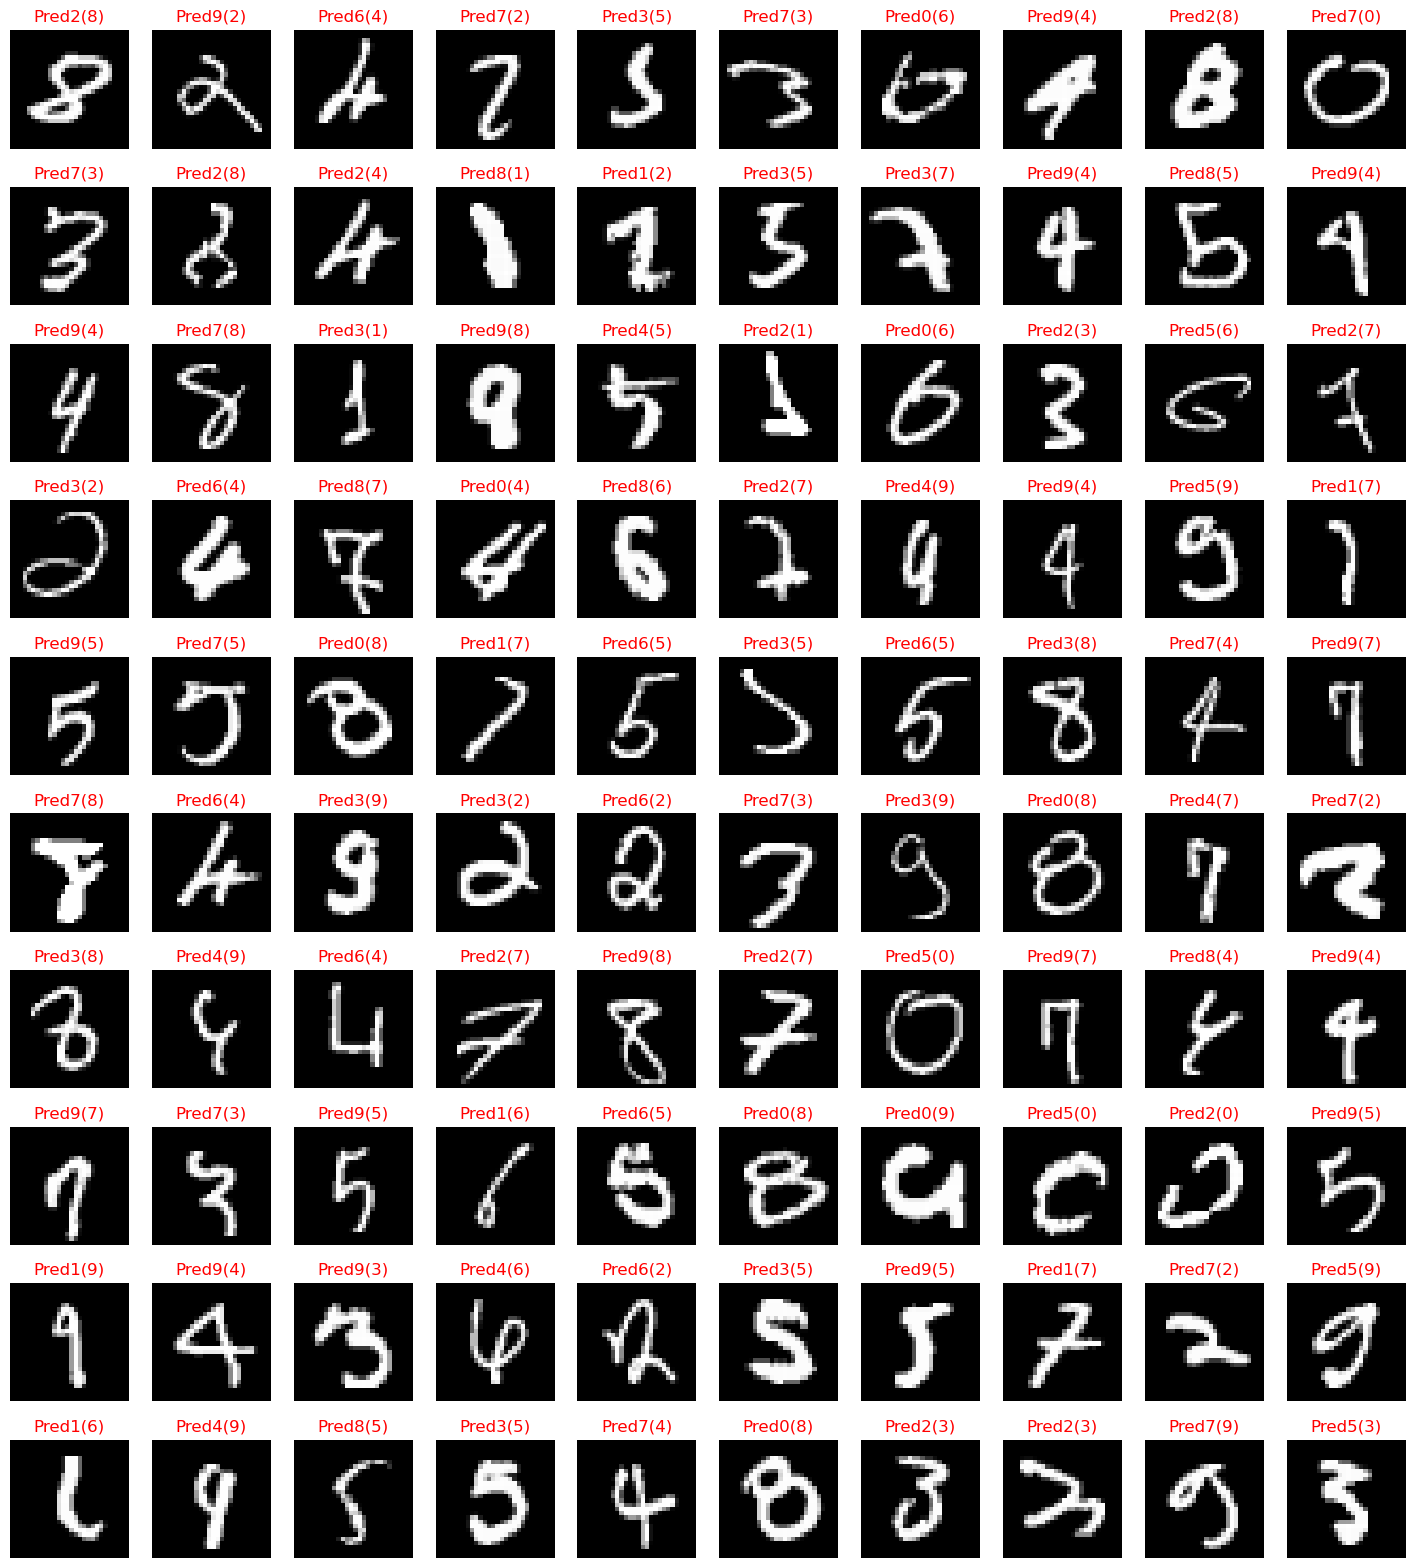

In [99]:
# incorrect 데이터 중, 100개 이미지만 출력해보기
# 주피터 노트북에서 그림을 주피터 노트북 내에 표시하도록 강제하는 명령
# %matplotlib inline 

plt.figure(figsize=(18 , 20))

for index in range(100):
    plt.subplot(10, 10, index + 1)
    plt.axis('off')
    plt.imshow(wrong_samples[index].numpy( ).reshape(28,28), cmap = "gray")
    plt.title("Pred" + str(wrong_preds[index].item()) + "(" + str(actual_preds[index].item()) + ")", color='red')